# 04. Data Processing

### Importando as bibliotecas

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from ydata_profiling import ProfileReport
import functions.fn_stats as fn_stats
import functions.fn_charts as fn_charts
import params.consts as consts

### Lendo o dataset

In [2]:
df = pd.read_csv(consts.DATABASE) # Armazenando o dataset em uma variável

df.head(3) # Exibindo as 3 primeiras linhas do dataset

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0


### Corrigindo os tipos de dados das colunas
- **Dt_Customer:** Convertendo essa coluna para o formato de data.

In [3]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%Y-%m-%d") # Convertendo a coluna para o formato de data

### Tratando as colunas com valores nulos
- **Income:** Como essa coluna possui apenas 24 valores nulos em um univeso de 2.240 (o que representa cerca de 1% da base), optamos por remover essas linhas para seguir o projeto.

In [4]:
df = df.dropna(subset=['Income']) # Removendo as linhas com valores nulos da coluna

### Criando colunas de tempo/idade
- **Dt_Customer => Days_Since_Enrolled:** Criando essa coluna para usá-la de forma mais apropriada para os modelos, onde a informação de tempo/idade é mais relevante que uma data.
- **Dt_Customer => Years_Since_Enrolled:** Criando essa coluna para usá-la de forma mais apropriada para os modelos, onde a informação de tempo/idade é mais relevante que uma data.
- **Year_Birth => Age:** Criando essa coluna para usá-la de forma mais apropriada para os modelos, onde a informação de tempo/idade é mais relevante que uma data.

In [5]:
df['Days_Since_Enrolled'] = df['Dt_Customer'].max() - df['Dt_Customer'] # Criando a coluna com a diferença do valor máximo das datas e a data de cadastro do cliente
df['Days_Since_Enrolled'] = df['Days_Since_Enrolled'].dt.days # Convertendo o tempo para dias
df['Years_Since_Enrolled'] = df['Days_Since_Enrolled'] // 365 # Criando a coluna apenas com anos inteiros (dividindo com 2 barras)
df['Age'] = df['Dt_Customer'].max().year - df['Year_Birth'] # Criando a coluna com a idade dos clientes, fixando o valor máximmo das datas da campanha para que as idades não fiquem variando de acordo com o tempo que o código é rodado

### Mesclando colunas com muitas categorias
- **AgeGroup:** Criando essa coluna para agrupar os dados em intervalos. 
- **Marital_Status:** Agrupando melhor os dados dessa coluna.

In [6]:
df['AgeGroup'] = pd.cut( # Criando essa coluna para agrupar as idades em intervalos padrões de cerca de 15 anos
    df['Age'], # Definindo a coluna que será usada para criar os intervalos
    bins=[18, 30, 45, 60, df['Age'].max()], # Definindo os intervalos
    labels=['18-30', '31-45', '46-60', '61+'], # Definindo os rótulos de como os dados vão aparecer no dataset
    include_lowest=True # Incluindo o valor inicial no intervalo
)
df['Marital_Status'] = df['Marital_Status'].replace( # Agrupando melhor os dados dessa coluna
    {
        'Alone': 'Single',
        'Absurd': 'Single',
        'YOLO': 'Single',
        'Together': 'Partner',
        'Married': 'Partner',
        'Widow': 'Single',
        'Single': 'Single',
        'Divorced': 'Single',
    }
)

In [7]:
df['AgeGroup'].value_counts() # Verificando o resultado da transformação na coluna

AgeGroup
31-45    965
46-60    727
61+      267
18-30    257
Name: count, dtype: int64

In [8]:
df['Marital_Status'].value_counts() # Verificando o resultado da transformação na coluna

Marital_Status
Partner    1430
Single      786
Name: count, dtype: int64

### Unificando / somando colunas semelhantes
- **Children:** Criando uma coluna com o total de dependentes do cliente.
- **MntTotal:** Criando uma coluna com o total gastos em todas as categorias de produtos.
- **AcceptedCmpTotal:** Criando uma coluna com o total de campanhas aceitas pelo cliente.
- **NumTotalPurchases:** Criando uma coluna com o total de compras feitas pelo cliente.

In [9]:
df['Children'] = df['Kidhome'] + df['Teenhome'] # Criando a coluna com o total de dependentes do cliente
df['MntTotal'] = ( # Criando a coluna com o total gasto em todas as categorias de produtos
    df['MntWines'] + 
    df['MntFruits'] + 
    df['MntMeatProducts'] + 
    df['MntFishProducts'] + 
    df['MntSweetProducts'] + 
    df['MntGoldProds']
)
df['AcceptedCmpTotal'] = ( # Criando a coluna com o total de campanhas aceitas pelo cliente
    df['AcceptedCmp1'] + 
    df['AcceptedCmp2'] + 
    df['AcceptedCmp3'] + 
    df['AcceptedCmp4'] + 
    df['AcceptedCmp5'] 
)
df['NumTotalPurchases'] = ( # Criando a coluna com o total de compras feitas pelo cliente
    df['NumWebPurchases'] + 
    df['NumCatalogPurchases'] + 
    df['NumStorePurchases'] 
)

In [10]:
df['Children'].value_counts() # Verificando o resultado da nova coluna

Children
1    1117
0     633
2     416
3      50
Name: count, dtype: int64

In [11]:
df['AcceptedCmpTotal'].value_counts() # Verificando o resultado da nova coluna

AcceptedCmpTotal
0    1757
1     323
2      81
3      44
4      11
Name: count, dtype: int64

### Criando colunas derivadas de outras
- **HasChildren:** Criando essa coluna caso o cliente tenha dependentes ou não.
- **MntRegularProds:** Criando essa coluna com o valor gasto somente em produtos regulares.
- **HasAcceptedCmp:** Criando essa coluna caso o cliente tenha aceito alguma campanha ou não.

In [12]:
df['HasChildren'] = df['Children'].apply(lambda x: 1 if x > 0 else 0) # Criando a coluna que verifica se o cliente tem dependentes através de uma função anônima (na própria linha de código)
df['MntRegularProds'] = df['MntTotal'] - df['MntGoldProds'] # Criando a coluna com o valor gasto somente em produtos regulares
df['HasAcceptedCmp'] = df['AcceptedCmpTotal'].apply(lambda x: 1 if x > 0 else 0) # Criando a coluna que verifica se o cliente já aceitou uma campanha através de uma função anônima (na própria linha de código)

### Visualizando o dataset antes de tratar outliers e excluir colunas

In [13]:
df.head(3) # Exibindo as 3 primeiras linhas do dataset

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Years_Since_Enrolled,Age,AgeGroup,Children,MntTotal,AcceptedCmpTotal,NumTotalPurchases,HasChildren,MntRegularProds,HasAcceptedCmp
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,1,57,46-60,0,1617,0,22,0,1529,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,60,46-60,2,27,0,4,1,21,0
2,4141,1965,Graduation,Partner,71613.0,0,0,2013-08-21,26,426,...,0,49,46-60,0,776,0,20,0,734,0


### Tratando as colunas com valores outliers
- **Age:** Como são poucos outliers dentro do universo dos dados, vamos remover as linhas desses outliers.
- **Income:** Como são poucos outliers dentro do universo dos dados, vamos remover as linhas desses outliers.
- **MntTotal:** Como são poucos outliers dentro do universo dos dados e estão muitos próximos do limite superior, vamos manter as linhas desses outliers.

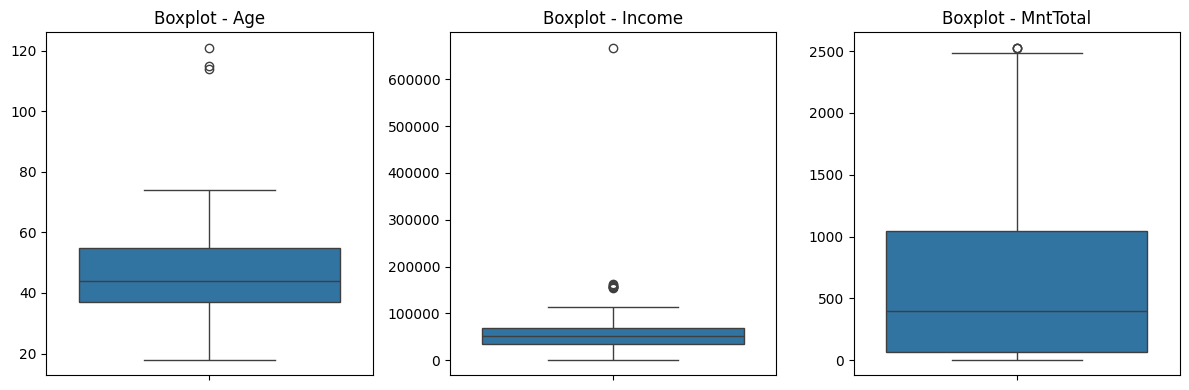

In [14]:
fn_charts.boxplots(df,  ['Age', 'Income', 'MntTotal']) # Exibindo os gráficos de boxplots

In [15]:
fn_stats.inspect_outliers(df, 'Age') # Usando a função para listar os outliers

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Years_Since_Enrolled,Age,AgeGroup,Children,MntTotal,AcceptedCmpTotal,NumTotalPurchases,HasChildren,MntRegularProds,HasAcceptedCmp
192,7829,1900,2n Cycle,Single,36640.0,1,0,2013-09-26,99,15,...,0,114,61+,1,65,0,5,1,40,0
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,0,121,61+,1,22,0,3,1,20,0
339,1150,1899,PhD,Partner,83532.0,0,0,2013-09-26,36,755,...,0,115,61+,0,1853,1,14,0,1629,1


In [16]:
fn_stats.inspect_outliers(df, 'Income') # Usando a função para listar os outliers

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Years_Since_Enrolled,Age,AgeGroup,Children,MntTotal,AcceptedCmpTotal,NumTotalPurchases,HasChildren,MntRegularProds,HasAcceptedCmp
164,8475,1973,PhD,Partner,157243.0,0,1,2014-03-01,98,20,...,0,41,31-45,1,1608,0,22,1,1607,0
617,1503,1976,PhD,Partner,162397.0,1,1,2013-06-03,31,85,...,1,38,31-45,2,107,0,1,1,105,0
655,5555,1975,Graduation,Single,153924.0,0,0,2014-02-07,81,1,...,0,39,31-45,0,6,0,0,0,5,0
687,1501,1982,PhD,Partner,160803.0,0,0,2012-08-04,21,55,...,1,32,31-45,0,1717,0,29,0,1713,0
1300,5336,1971,Master,Partner,157733.0,1,0,2013-06-04,37,39,...,1,43,31-45,1,59,0,2,1,51,0
1653,4931,1977,Graduation,Partner,157146.0,0,0,2013-04-29,13,1,...,1,37,31-45,0,1730,0,28,0,1729,0
2132,11181,1949,PhD,Partner,156924.0,0,0,2013-08-29,85,2,...,0,65,61+,0,8,0,0,0,7,0
2233,9432,1977,Graduation,Partner,666666.0,1,0,2013-06-02,23,9,...,1,37,31-45,1,62,0,7,1,50,0


In [17]:
df = df.drop(fn_stats.inspect_outliers(df,'Age').index) # Removendo os outliers 
df = df.drop(fn_stats.inspect_outliers(df,'Income').index) # Removendo os outliers 

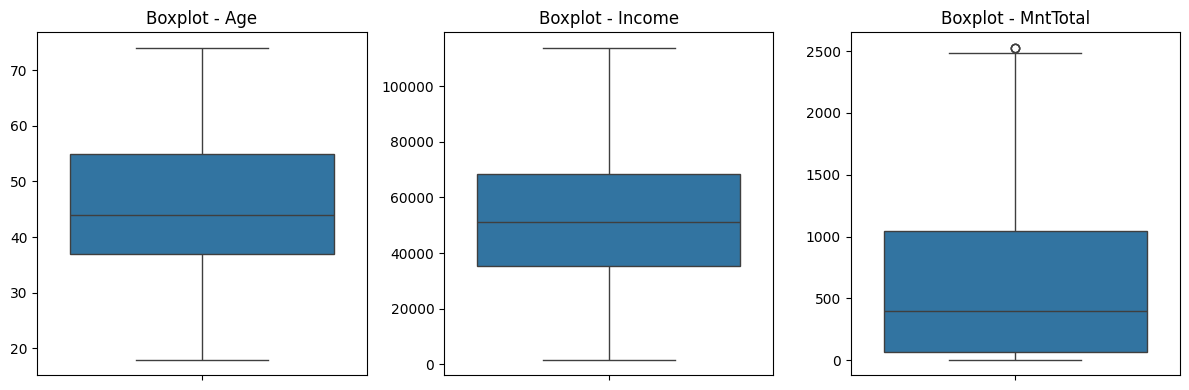

In [18]:
fn_charts.boxplots(df,  ['Age', 'Income', 'MntTotal']) # Exibindo os gráficos de boxplots

### Excluindo as colunas que contém valores únicos
- **ID:** Excluindo a coluna ID para deixar o dataset apenas com informações relevantes, já que uma coluna com identificadores únicos para cada cliente não acrescenta em nada nesse estudo. E lembrando que ao remover a coluna de identificação única, é possível que o dataset passe a ter linhas duplicadas.

In [19]:
df = df.drop('ID', axis=1) # Excluindo as colunas com valores únicos

### Excluindo as colunas que contém valores constantes
- **Z_CostContact:** Excluindo a coluna Z_CostContact para deixar o dataset apenas com informações relevantes, já que uma coluna com valores únicos não acrescenta em nada nesse estudo.
- **Z_Revenue:** Excluindo a coluna Z_Revenue para deixar o dataset apenas com informações relevantes, já que uma coluna com valores únicos não acrescenta em nada nesse estudo.

In [20]:
df = df.drop(['Z_CostContact', 'Z_Revenue'], axis=1) # Excluindo as colunas com valores constantes

### Excluindo as colunas auxiliares
- **Dt_Customer:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **Year_Birth:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **Age:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **Kidhome:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **Teenhome:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **Children:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **MntWines:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **MntFruits:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **MntMeatProducts:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **MntFishProducts:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **MntSweetProducts:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **AcceptedCmp1:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **AcceptedCmp2:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **AcceptedCmp3:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **AcceptedCmp4:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **AcceptedCmp5:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **NumWebPurchases:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **NumCatalogPurchases:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.
- **NumStorePurchases:** Excluindo a coluna para deixar o dataset apenas com informações relevantes.

In [21]:
df = df.drop( # Excluindo as colunas auxiliares
    [ 
        'Dt_Customer', 
        'Year_Birth', 
        'Age', 
        'Kidhome',
        'Teenhome',
        'Children',
        'MntWines', 
        'MntFruits', 
        'MntMeatProducts', 
        'MntFishProducts', 
        'MntSweetProducts',
        'AcceptedCmp1',
        'AcceptedCmp2',
        'AcceptedCmp3',
        'AcceptedCmp4',
        'AcceptedCmp5', 
        'NumWebPurchases', 
        'NumCatalogPurchases', 
        'NumStorePurchases', 
    ], 
    axis=1 # Definindo que colunas serão excluídas
) 

### Ordenando as colunas relacionadas

In [22]:
df = df.reindex(columns=[ # Ordenando as colunas em uma ordem que faz mais sentido para análises
        'Education', 
        'Marital_Status', 
        'HasChildren',
        'AgeGroup',
        'Income',
        'Recency',
        'Complain',
        'Days_Since_Enrolled',
        'Years_Since_Enrolled',
        'NumDealsPurchases',
        'NumWebVisitsMonth',
        'NumTotalPurchases',
        'MntRegularProds',
        'MntGoldProds',
        'MntTotal',
        'AcceptedCmpTotal',
        'HasAcceptedCmp',
        'Response',
    ]
)

### Salvando o dataset processado

In [23]:
df.to_csv(consts.PROCESSED_DATABASE, index=False) # Exportando o dataset tratado

### Gerando um novo relatório Profile Report

In [24]:
profile = ProfileReport(df) # Armazenando em uma variável o ProfileReport

profile.to_file('../reports/eda_1.html') # Salvando o profile report na pasta reports e

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]